## Applying a 3D convolutional neural network to the data ##

Welcome everyone to my coverage of the Kaggle Data Science Bowl 2017. My goal here is that anyone, even people new to kaggle, can follow along. If you are completely new to data science, I will do my best to link to tutorials and provide information on everything you need to take part.

This notebook is my actual personal initial run through this data and my notes along the way. I am by no means an expert data analyst, statistician, and certainly not a doctor. This initial pass is not going to win the competition, but hopefully it can serve as a starting point or, at the very least, you can learn something new along with me.

This is a "raw" look into the actual code I used on my first pass, there's a ton of room for improvment. If you see something that you could improve, share it with me!

## Quick introduction to Kaggle ##
<iframe width="560" height="315" src="https://www.youtube.com/embed/ulq9DjCJPDU?list=PLQVvvaa0QuDd5meH8cStO9cMi98tPT12_" frameborder="0" allowfullscreen></iframe>

If you are new to kaggle, create an account, and start downloading the data. It's going to take a while. I found the torrent to download the fastest, so I'd suggest you go that route. When you create an account, head to competitions in the nav bar, choose the Data Science Bowl, then head to the "data" tab. You will need to accept the terms of the competition to proceed with downloading the data.

Just in case you are new, how does all this work?

In general, Kaggle competitions will come with training and testing data for you to build a model on, where both the training and testing data comes with labels so you can fit a model. Then there will be actual "blind" or "out of sample" testing data that you will actually use your model on, which will spit out an output CSV file with your predictions based on the input data. This is what you will upload to kaggle, and your score here is what you compete with. There's always a sample submission file in the dataset, so you can see how to exactly format your output predictions.

In this case, the submission file should have two columns, one for the patient's id and another for the prediction of the liklihood that this patient has cancer, like:

id,cancer
01e349d34c02410e1da273add27be25c,0.5
05a20caf6ab6df4643644c923f06a5eb,0.5
0d12f1c627df49eb223771c28548350e,0.5
...

You can submit up to 3 entries a day, so you want to be very happy with your model, and you are at least slightly disincentivised from trying to simply fit the answer key over time. It's still possible to cheat. If you do cheat, you wont win anything, since you will have to disclose your model for any prizes.

At the end, you can submit 2 final submissions (allowing you to compete with 2 models if you like).
This current competition is a 2 stage competition, where you have to participate in both stages to win. 

Stage one has you competing based on a validation dataset. At the release of stage 2, the validation set answers are released and then you make predictions on a new test set that comes out at the release of this second stage.

## About this specific competition ##

At its core, the aim here is to take the sample data, consisting of low-dose CT scan information, and predict what the liklihood of a patient having lung cancer is. Your submission is scored based on the log loss of your predictions.

The dataset is pretty large at ~140GB just in initial training data, so this can be somewhat restrictive right out of the gate. I am going to do my best to make this tutorial one that anyone can follow within the built-in Kaggle kernels

## Requirements and suggestions for following along ## 

I will be using Python 3, and you should at least know the [basics][1] of Python 3.

We will also be making use of: 

[Pandas for some data analysis][2]

[Matplotlib for data visualization][3]

You do not need to go through all of those tutorials to follow here, but, if you are confused, it might be useful to poke around those.
For the actual dependency installs and such, I will link to them as we go.


  [1]: https://pythonprogramming.net/introduction-to-python-programming/
  [2]: https://pythonprogramming.net/data-analysis-python-pandas-tutorial-introduction/
  [3]: https://pythonprogramming.net/matplotlib-intro-tutorial/

## Alright, let's get started! ##

# Section 1: Handling Data #

Assuming you've downloaded the data, what exactly are we working with here? The data consists of many 2D "slices," which, when combined, produce a 3-dimensional rendering of whatever was scanned. In this case, that's the chest cavity of the patient. We've got CT scans of about 1500 patients, and then we've got another file that contains the labels for this data.

There are numerous ways that we could go about creating a classifier. Being a realistic data science problem, we actually don't really know what the best path is going to be. That's why this is a competition. Thus, we have to begin by simply trying things and seeing what happens!

I have a few theories about what might work, but my first interest was to try a 3D Convolutional Neural Network. I've never had data to try one on before, so I was excited to try my hand at it!

Before we can feed the data through any model, however, we need to at least understand the data we're working with. We know the scans are in this "dicom" format, but what is that? If you're like me, you have no idea what that is, or how it will look in Python! You can [learn more about DICOM from Wikipedia][1] if you like, but our main focus is what this will actually be in Python terms.

Luckily for us, there already exists a Python package for reading dicom files: [Pydicom][2].

Do a *pip install pydicom* and *pip install pandas* and let's see what we've got!

<iframe width="560" height="315" src="https://www.youtube.com/embed/KlffppN47lc?list=PLQVvvaa0QuDd5meH8cStO9cMi98tPT12_" frameborder="0" allowfullscreen></iframe>

  [1]: https://en.wikipedia.org/wiki/DICOM
  [2]: https://pypi.python.org/pypi/pydicom

In [19]:
import dicom # for reading dicom files
import os # for doing directory operations 
import pandas as pd # for some simple data analysis (right now, just to load in the labels data and quickly reference it)

# Change this to wherever you are storing your data:
# IF YOU ARE FOLLOWING ON KAGGLE, YOU CAN ONLY PLAY WITH THE SAMPLE DATA, WHICH IS MUCH SMALLER

data_dir = 'G:/Lung/sample_images/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('G:/Lung/stage1_labels/stage1_labels.csv', index_col=0)

labels_df.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


At this point, we've got the list of patients by their IDs, and their associated labels stored in a dataframe. Now, we can begin to iterate through the patients and gather their respective data. We're almost certainly going to need to do some preprocessing of this data, but we'll see.

In [20]:
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    
    # a couple great 1-liners from: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(len(slices),label)
    print(slices[0])

134 0
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113654.2.55.247817952625791837963403492891187883824
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0010) Patient's Name                      PN: '00cba091fa4ad62cc3200a657aeb957e'
(0010, 0020) Patient ID                          LO: '00cba091fa4ad62cc3200a657aeb957e'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 000d) Study Instance UID                  UI: 2.25.86208730140539712382771890501772734277950692397709007305473
(0020, 000e) Series Instance UID                 UI: 2.25.11575877329635228925808596800269974740893519451784626046614
(0020, 0011) Series Number                       IS: '3'
(0020, 0012) Acquisition Number      

Above, we iterate through each patient, we grab their label, we get the full path to that specific patient (inside THAT path contains ~200ish scans which we also iterate over, BUT also want to sort, since they wont necessarily be in proper order).

Do note here that the actual scan, when loaded by dicom, is clearly not JUST some sort of array of values, instead it's got attributes. There are a few attributes here of arrays, but not all of them. We're sorting by the actual image position in the scan. Later, we could actually put these together to get a full 3D rendering of the scan. That's not in my plans here, since that's already been something covered very well, see this kernel: [https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial][1]

One immediate thing to note here is those rows and columns...holy moly, 512 x 512! This means, our 3D rendering is a 195 x 512 x 512 right now. That's huge!

Alright, so we already know that we're going to absolutely need to resize this data. Being 512 x 512, I am already expecting all this data to be the same size, but let's see what we have from other patients too:


  [1]: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial

In [21]:
for patient in patients[:3]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    
    # a couple great 1-liners from: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(slices[0].pixel_array.shape, len(slices))

(512, 512) 134
(512, 512) 128
(512, 512) 133


Alright, so above we just went ahead and grabbed the pixel_array attribute, which is what I assume to be the scan slice itself (we will confirm this soon), but immediately I am surprised by this non-uniformity of slices. This isn't quite ideal and will cause a problem later. All of our images are the same size, but the slices arent. In terms of a 3D rendering, these actually are not the same size.

We've got to actually figure out a way to solve that uniformity problem, but also...these images are just WAY too big for a convolutional neural network to handle without some serious computing power.
Thus, we already know out of the gate that we're going to need to downsample this data quite a bit, AND somehow make the depth uniform.

*Welcome to datascience!*

Okay, next question is...just how much data do we have here?

In [22]:
len(patients)

19

Oh. 

(1595 in real data, 20 if you're in the Kaggle sample dataset)

Well, that's also going to be a challenge for the convnet to figure out, but we're going to try! Also, there are outside datasources for more lung scans. For example, you can grab data from the LUNA2016 challenge: https://luna16.grand-challenge.org/data/ for another 888 scans.

Do note that, if you do wish to compete, you can only use free datasets that are available to anyone who bothers to look.

I'll have us stick to just the base dataset, again mainly so anyone can poke around this code in the kernel environment.

Now, let's see what an actual slice looks like. If you do not have matplotlib, do *pip install matplotlib*

<iframe width="560" height="315" src="https://www.youtube.com/embed/MqcZYw8Tgpc?list=PLQVvvaa0QuDd5meH8cStO9cMi98tPT12_" frameborder="0" allowfullscreen></iframe>

Want to learn more about Matplotlib? Check out the [Data Visualization with Python and Matplotlib tutorial][1].


  [1]: https://pythonprogramming.net/matplotlib-intro-tutorial/

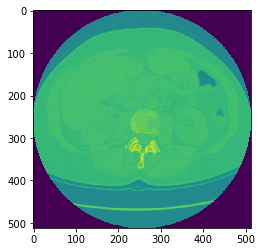

In [23]:
import matplotlib.pyplot as plt

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    #          the first slice
    plt.imshow(slices[0].pixel_array)
    plt.show()

Now, I am not a doctor, but I'm going to claim a mini-victory and say that's our first CT scan slice.

We have about 200 slices though, I'd feel more comfortable if I saw a few more. Let's look at the first 12, and resize them with opencv. If you do not have opencv, do a *pip install cv2*

Want to learn more about what you can do with Open CV? Check out the [Image analysis and manipulation with OpenCV and Python tutorial][1].

You will also need numpy here. You probably already have numpy if you installed pandas, but, just in case, numpy is *pip install numpy*


  [1]: https://pythonprogramming.net/loading-images-python-opencv-tutorial/

# Section 2: Processing and viewing our Data #

<iframe width="560" height="315" src="https://www.youtube.com/embed/lqhMTkouBx0?list=PLQVvvaa0QuDd5meH8cStO9cMi98tPT12_" frameborder="0" allowfullscreen></iframe>

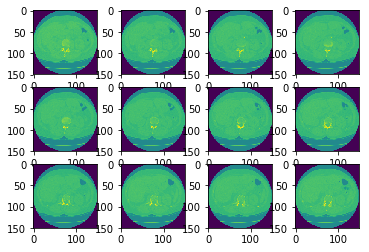

In [24]:
import cv2
import numpy as np

IMG_PX_SIZE = 150

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    fig = plt.figure()
    for num,each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4,num+1)
        new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_img)
    plt.show()

Alright, so we're resizing our images from 512x512 to 150x150. 150 is still going to wind up likely being waaaaaaay to big. That's fine, we can play with that constant more later, we just want to know how to do it.

Okay, so now what? I think we need to address the whole non-uniformity of depth next. To be honest, I don't know of any super smooth way of doing this, but that's fine. I can at least think of A way, and that's all we need.

My thought is that, what we have is really a big list of slices. What we need is to be able to just take any list of images, whether it's got 200 scans, 150 scans, or 300 scans, and set it to be some fixed number.
Let's say we want to have 20 scans instead. How can we do this?
Well, first, we need something that will take our current list of scans, and chunk it into a list of lists of scans.

I couldn't think of anything off the top of my head for this, so I Googled "how to chunk a list into a list of lists." This is how real programming is happens.

As per Ned Batchelder via Link: [http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks][1], we've got ourselves a nice chunker generator. Awesome!

Thanks Ned!

Okay, once we've got these chunks of these scans, what are we going to do? Well, we can just average them together. My theory is that a scan is a few millimeters of actual tissue at most. Thus, we can hopefully just average this slice together, and maybe we're now working with a centimeter or so. If there's a growth there, it should still show up on scan.

This is just a theory, it has to be tested.

As we continue through this, however, you're hopefully going to see just how many theories we come up with, and how many variables we can tweak and change to possibly get better results.


  [1]: http://%20http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks

In [26]:
import math

def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mean(l):
    return sum(l) / len(l)

IMG_PX_SIZE = 150
HM_SLICES = 20

data_dir = 'G:/Lung/sample_images/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('G:/Lung/stage1_labels/stage1_labels.csv', index_col=0)

for patient in patients[:10]:
    try:
        label = labels_df.get_value(patient, 'cancer')
        path = data_dir + patient
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []
        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
        chunk_sizes = math.ceil(len(slices) / HM_SLICES)
        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        print(len(slices), len(new_slices))
    except:
        # some patients don't have labels, so we'll just pass on this for now
        pass

134 20
128 19
133 19
110 19
203 19
280 20
123 18
164 19
244 19
136 20


The struggle is real. Okay, what you're about to see you shouldn't attempt if anyone else is watching, like if you're going to show your code to the public...

In [27]:
for patient in patients[:10]:
    try:
        label = labels_df.get_value(patient, 'cancer')
        path = data_dir + patient
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []

        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]

        chunk_sizes = math.ceil(len(slices) / HM_SLICES)


        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        if len(new_slices) == HM_SLICES-1:
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES+2:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        if len(new_slices) == HM_SLICES+1:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        print(len(slices), len(new_slices))
    except Exception as e:
        # again, some patients are not labeled, but JIC we still want the error if something
        # else is wrong with our code
        print(str(e))

134 20
128 20
133 20
110 20
203 20
280 20
123 20
164 20
244 20
136 20


Okay, the Python gods are really not happy with me for that hacky solution. If any of you would like to improve this chunking/averaging code, feel free. Really, any of this code...if you have improvements, share them! This is going to stay pretty messy. But hey, we did it! We figured out a way to make sure our 3 dimensional data can be at any resolution we want or need. Awesome!

That's actually a decently large hurdle. Are we totally done? ...maybe not. One major issue is these colors and ranges of data. It's unclear to me whether or not a model would appreciate that. Even if we do a grayscale colormap in the imshow, you'll see that some scans are just darker overall than others. This might be problematic and we might need to actually normalize this dataset.

I expect that, with a large enough dataset, this wouldn't be an actual issue, but, with this size of data, it might be of huge importance.

In effort to not turn this notebook into an actual book, however, we're going to move forward! We can now see our new data by doing:

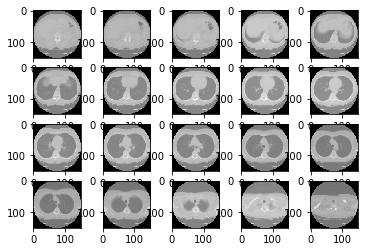

In [28]:
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    new_slices = []

    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / HM_SLICES)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
        
    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
    
    fig = plt.figure()
    for num,each_slice in enumerate(new_slices):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(each_slice, cmap='gray')
    plt.show()

# Section 3: Preprocessing our Data #

<iframe width="560" height="315" src="https://www.youtube.com/embed/_DAeMDMHgtY?list=PLQVvvaa0QuDd5meH8cStO9cMi98tPT12_" frameborder="0" allowfullscreen></iframe>

Okay, so we know what we've got, and what we need to do with it.

We have a few options at this point, we could take the code that we have already and do the processing "online." By this, I mean, while training the network, we can actually just loop over our patients, resize the data, then feed it through our neural network. We actually don't have to have all of the data prepared before we go through the network.

If you can preprocess all of the data into one file, and that one file doesn't exceed your available memory, then training should likely be faster, so you can more easily tweak your neural network and not be processing your data the same way over and over.

In many more realistic examples in the world, however, your dataset will be so large, that you wouldn't be able to read it all into memory at once anyway, but you could still maintain one big database or something.

Bottom line: There are tons of options here. Our dataset is only 1500 (even less if you are following in the Kaggle kernel) patients, and will be, for example, 20 slices of 150x150 image data if we went off the numbers we have now, but this will need to be even smaller for a typical computer most likely. 

Regardless, this much data wont be an issue to keep in memory or do whatever the heck we want.

If at all possible, I prefer to separate out steps in any big process like this, so I am going to go ahead and pre-process the data, so our neural network code is much simpler. Also, there's no good reason to maintain a network in GPU memory while we're wasting time processing the data which can be easily done on a CPU.

Now, I will just make a slight modification to all of the code up to this point, and add some new final lines to preprocess this data and save the array of arrays to a file:

In [31]:
import numpy as np
import pandas as pd
import dicom
import os
import matplotlib.pyplot as plt
import cv2
import math

IMG_SIZE_PX = 50
SLICE_COUNT = 20

def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


def mean(a):
    return sum(a) / len(a)


def process_data(patient,labels_df,img_px_size=50, hm_slices=20, visualize=False):
    
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == hm_slices-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == hm_slices+1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()

    if label == 1: label=np.array([0,1])
    elif label == 0: label=np.array([1,0])
        
    return np.array(new_slices),label

#                                               stage 1 for real.
data_dir = 'G:/Lung/sample_images/'
patients = os.listdir(data_dir)
labels= pd.read_csv('G:/Lung/stage1_labels/stage1_labels.csv', index_col=0)

much_data = []
for num,patient in enumerate(patients):
    if num % 100 == 0:
        print(num)
    try:
        img_data,label = process_data(patient,labels,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
        much_data.append([img_data,label])
    except KeyError as e:
        print('This is unlabeled data!')

np.save('muchdata-{}-{}-{}.npy'.format(IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT), much_data)

0


# Section 4: 3D Convolutional Neural Network #

##Moment-o-truth##

<iframe width="560" height="315" src="https://www.youtube.com/embed/CPZ5ihaNfJc?list=PLQVvvaa0QuDd5meH8cStO9cMi98tPT12_" frameborder="0" allowfullscreen></iframe>

Okay, we've got preprocessed, normalized, data. Now we're ready to feed it through our 3D convnet and...see what happens!

Now, I am not about to stuff a neural networks tutorial into this one. If you're already familiar with neural networks and TensorFlow, great! If not, as you might guess, I have a tutorial...or tutorials... for you!

To install the CPU version of TensorFlow, just do *pip install tensorflow*

To install the GPU version of TensorFlow, you need to get alllll the dependencies and such.

**Installation tutorials:**

[Installing the GPU version of TensorFlow in Ubuntu][1]

[Installing the GPU version of TensorFlow on a Windows machine][2]

**Using TensorFlow and concept tutorials:**

[Introduction to deep learning with neural networks][3]

[Introduction to TensorFlow][4] 

[Intro to Convolutional Neural Networks][5]

[Convolutional Neural Network in TensorFlow tutorial][6]

Now, the data we have is actually 3D data, not 2D data that's covered in most convnet tutorials, including mine above. So what changes? EVERYTHING! OMG IT'S THE END OF THE WORLD AS WE KNOW IT!!

It's not really all too bad. Your convolutional window/padding/strides need to change. Do note that, now, to have a bigger window, your processing penalty increases significantly as we increase in size, obviously much more than with 2D windows.

Okay, let's begin.


  [1]: https://pythonprogramming.net/how-to-cuda-gpu-tensorflow-deep-learning-tutorial/
  [2]: https://www.youtube.com/watch?v=r7-WPbx8VuY
  [3]: https://pythonprogramming.net/neural-networks-machine-learning-tutorial
  [4]: https://pythonprogramming.net/tensorflow-introduction-machine-learning-tutorial/
  [5]: https://pythonprogramming.net/convolutional-neural-network-cnn-machine-learning-tutorial/
  [6]: https://pythonprogramming.net/cnn-tensorflow-convolutional-nerual-network-machine-learning-tutorial/

In [32]:
import tensorflow as tf
import numpy as np

IMG_SIZE_PX = 50
SLICE_COUNT = 20

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

Now we're ready for the network itself:

In [ ]:
def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

Why 54080 magic number? To get this, I simply run the script once, and see what the error yells at me for the expected size multiple. This is certainly not the right way to go about it, but that's my 100% honest method, and my first time working in a 3D convnet. AFAIK, it's the padding that causes this to not be EXACTLY 50,000, (50 x 50 x 20 is the size of our actual input data, which is 50,000 total). 

Someone feel free to enlighten me how one could actually calculate this number beforehand. 

Now we're set to train the network. I am not going to ask the Kaggle online kernel to even bother building this computation graph, so I will comment out the line to actually run this. Just uncomment it locally and it will run. When running locally, make sure your training data is NOT the sample images, it should be the stage1 images. Your training file should be ~700mb with ~1400 total labeled samples.

In [ ]:
much_data = np.load('muchdata-50-50-20.npy')
# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
train_data = much_data[:-100]
validation_data = much_data[-100:]


def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(prediction,y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    hm_epochs = 10
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    # I am passing for the sake of notebook space, but we are getting 1 shaping issue from one 
                    # input tensor. Not sure why, will have to look into it. Guessing it's
                    # one of the depths that doesn't come to 20.
                    pass
                    #print(str(e))
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        print('fitment percent:',successful_runs/total_runs)

# Run this locally:
# train_neural_network(x)

Example output that I got:

    Epoch 1 completed out of 10 loss: 195148607547.0

Accuracy: 0.63

Epoch 2 completed out of 10 loss: 14236109414.9

Accuracy: 0.6

Epoch 3 completed out of 10 loss: 5744945978.94

Accuracy: 0.7

Epoch 4 completed out of 10 loss: 3268944715.44

Accuracy: 0.6

Epoch 5 completed out of 10 loss: 1916325681.66

Accuracy: 0.6

Epoch 6 completed out of 10 loss: 1014763813.3

Accuracy: 0.46

Epoch 7 completed out of 10 loss: 680146186.953

Accuracy: 0.54

Epoch 8 completed out of 10 loss: 289082075.259

Accuracy: 0.62

Epoch 9 completed out of 10 loss: 122785997.913

Accuracy: 0.57

Epoch 10 completed out of 10 loss: 96427552.5371

Accuracy: 0.51

Done. Finishing accuracy:

Accuracy: 0.69

fitment percent: 0.9992289899768697

# Section 5: Concluding Remarks #

So how did we do? Well, we overfit almost certainly. How about our accuracy? Due to the lower amount of data on Kaggle, I have no idea what number you're seeing, just know it's probably not all that great. Even if it was, what was the number to beat? Was it 50%, since it's either cancer or not? Not quite. The real number we need to beat is if our network was to always predict a single class. Let's see what the best score our classifer could get is if it just always picked the most common class:

In [ ]:
labels_df.cancer.value_counts()

So, actually, our dataset has 1035 non-cancer examples and 362 cancerous examples. Thus, an algorithm that always predicted no-cancer with our model would be ~ 74% accurate (1035/1397).

We'd definitely want to confirm our testing set actually has this ratio before assuming anything. It might be the case our testing set has more cancerous examples, or maybe less, we really don't know. We can though:

In [ ]:
labels_df.ix[-100:].cancer.value_counts()

In this case, it's pretty close. No cancer always would give us 72% accuracy. In our test, that's the real number to beat.

All this said, this specific competition isn't actually just "right" or wrong. Your job is to predict % chance of cancer, it's not so binary.

## Now what? ##

Well, likely the largest issue here is our size of data. If we're going to be successful with a neural network, we need more data. We can either hunt for more outside datasources, or we can engage in adding some noise to the data.

It might also just simply be the case that a neural network isn't the best model of choice here. Neural networks are capable of amazing things, only when we have the datasets to support it. We might just simply not have enough data.

 1. Create new data from the existing data by adding noise. There are
    many ways to add "noise" to data. With pictures, we can do all sorts
    of things. Overlaying other pictures on top, rotating, messing with
    edges, adding various transforms...the list goes on and on. Before
    just adding any noise, it would be wise to research what exactly
    doctors do when analyzing CT scans for cancerous tumors. For
    example, you can check out this tutorial:
    [https://www.kaggle.com/c/data-science-bowl-2017/discussion/27922][1]
    for how an actual doctor reads a CT scan. You wouldn't want to add
    noise that conflicts here most likely.
 2. Bring in more outside data. I'd start here:
    [https://www.kaggle.com/c/data-science-bowl-2017/discussion/27666][2]
    "official external data" thread.
 3. Consider neural network variables, like layers, learning rate,
    activation functions, optimizer...etc.
 4. Consider other models. 
 5. Keep hacking away!

  [1]: https://www.kaggle.com/c/data-science-bowl-2017/discussion/27922
  [2]: https://www.kaggle.com/c/data-science-bowl-2017/discussion/27666